**策略想法**

往上突破第一條布林做多:
    -達到第二條布林平掉(TP)
    -跌回均線平掉(SL)

往下突破第一條布林做空:
    -達到第二條布林平掉(TP)
    -升回均線平掉(SL)

In [36]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import rcParams
import yfinance as yf
import requests
import time


# 設置繁體中文字型
rcParams['font.family'] = 'Microsoft JhengHei'  # 微軟正黑體
rcParams['axes.unicode_minus'] = False  # 解決負號顯示問題

# Get vxx data

In [37]:
# 下載VIX數據
vxx = yf.download("VXX", start="2018-09-02", end="2025-01-02")
vxx


[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-09-04,1889.280029,1917.439941,1873.920044,1873.920044,1873.920044,303
2018-09-05,1920.000000,1930.239990,1884.160034,1885.439941,1885.439941,91
2018-09-06,1934.079956,1979.520020,1914.880005,1943.040039,1943.040039,766
2018-09-07,1987.839966,2000.000000,1955.199951,1971.839966,1971.839966,123
2018-09-10,1939.839966,1939.839966,1905.920044,1918.719971,1918.719971,155
...,...,...,...,...,...,...
2024-12-24,43.970001,44.049999,42.180000,42.279999,42.279999,2884300
2024-12-26,42.610001,44.015999,42.255001,42.549999,42.549999,3616100
2024-12-27,43.180000,46.869999,43.088001,44.430000,44.430000,5905700


# Def

In [38]:

class VIXBollingerStrategy:
    def __init__(self, data, period=20):
        """
        初始化布林帶策略
        :param data: VIX期貨數據
        :param period: 布林帶周期
        """
        self.data = data.copy()
        self.period = period
        self.trades = []  # 用於存儲所有交易記錄
        
    def calculate_bollinger_bands(self):
        """計算布林帶"""
        # 計算移動平均線
        self.data['MA'] = self.data['Close'].rolling(window=self.period).mean()
        # 計算標準差
        rolling_std = self.data['Close'].rolling(window=self.period).std()
        
        # 計算布林帶（1個標準差和2個標準差）
        self.data['Upper_Band1'] = self.data['MA'] + rolling_std
        self.data['Lower_Band1'] = self.data['MA'] - rolling_std
        self.data['Upper_Band2'] = self.data['MA'] + 2 * rolling_std
        self.data['Lower_Band2'] = self.data['MA'] - 2 * rolling_std
        
        return self.data
    
    def calculate_signals(self):
        """計算交易信號"""
        # 初始化信號和倉位
        self.data['Signal'] = 0
        self.data['Position'] = 0
        
        # 多頭信號條件：從下往上突破第一條布林線上軌（1個標準差）
        long_signal = (self.data['Close'] > self.data['Upper_Band1']) & \
                     (self.data['Close'].shift(1) <= self.data['Upper_Band1'].shift(1))
        
        # 空頭信號條件：從上往下突破第一條布林線下軌（1個標準差）
        short_signal = (self.data['Close'] < self.data['Lower_Band1']) & \
                      (self.data['Close'].shift(1) >= self.data['Lower_Band1'].shift(1))
        
        # 設置信號
        self.data.loc[long_signal, 'Signal'] = 1
        self.data.loc[short_signal, 'Signal'] = -1
        
        # 設置隔日實際倉位 
        self.data['Position'] = self.data['Signal'].shift(1)
        self.data['Position'] = self.data['Position'].fillna(0)
        
        # 處理平倉條件
        current_trade = None
        for i in range(1, len(self.data)):
            # 確認新開倉
            if self.data['Position'].iloc[i] != 0 and self.data['Position'].iloc[i-1] == 0:
                if current_trade is None:  # 確保沒有未平倉的交易
                    current_trade = {
                        'entry_date': self.data.index[i],
                        'entry_price': self.data['Open'].iloc[i],
                        'position': self.data['Position'].iloc[i]
                    }
                    print(f"開倉: {self.data.index[i]}, 價格: {self.data['Open'].iloc[i]}")
            
            # 確認是否需要平倉
            if current_trade is not None:
                exit_signal = False
                
                if current_trade['position'] == 1:  # 多頭
                    if (self.data['Close'].iloc[i] >= self.data['Upper_Band2'].iloc[i] or 
                        self.data['Close'].iloc[i] <= self.data['MA'].iloc[i]):
                        exit_signal = True
                        
                elif current_trade['position'] == -1:  # 空頭
                    if (self.data['Close'].iloc[i] <= self.data['Lower_Band2'].iloc[i] or
                        self.data['Close'].iloc[i] >= self.data['MA'].iloc[i]):
                        exit_signal = True
                
                if exit_signal:
                    self.data.loc[self.data.index[i+1:i+2], 'Position'] = 0
                    current_trade['exit_date'] = self.data.index[i+1]
                    current_trade['exit_price'] = self.data['Open'].iloc[i+1]
                    print(f"平倉: {self.data.index[i+1]}, 價格: {self.data['Open'].iloc[i+1]}")
                    self.trades.append(current_trade)
                    current_trade = None
                    
        # 確保最後一筆交易有正確記錄
        if current_trade is not None:
            print(f"警告：有未平倉交易，最後進場日期: {current_trade['entry_date']}")
                        
        # 檢查每日的信號是否正確
        self.data[['Close', 'Signal', 'Position', 'Upper_Band1', 'Lower_Band1']].to_csv("debug_signals.csv")

        return self.data
    
    def analyze_trades(self):
        """分析交易統計數據"""
        if not self.trades:
            return "No trades found"
        
        # 轉換為DataFrame以便分析
        trades_df = pd.DataFrame(self.trades)
        
        # 計算每筆交易的收益率
        trades_df['return'] = np.where(
            trades_df['position'] == 1,
            (trades_df['exit_price'] - trades_df['entry_price']) / trades_df['entry_price'],
            (trades_df['entry_price'] - trades_df['exit_price']) / trades_df['entry_price']
        )
        
        # 計算持倉時間（以天為單位）
        trades_df['holding_period'] = (trades_df['exit_date'] - trades_df['entry_date']).dt.days
        
        # 計算統計數據
        total_trades = len(trades_df)
        winning_trades = len(trades_df[trades_df['return'] > 0])
        win_rate = winning_trades / total_trades if total_trades > 0 else 0
        
        avg_holding_period = trades_df['holding_period'].mean()
        max_holding_period = trades_df['holding_period'].max()
        min_holding_period = trades_df['holding_period'].min()
        
        avg_win_return = trades_df[trades_df['return'] > 0]['return'].mean() if winning_trades > 0 else 0
        avg_loss_return = trades_df[trades_df['return'] <= 0]['return'].mean() if (total_trades - winning_trades) > 0 else 0
        
        trade_stats = {
            '總交易次數': total_trades,
            '獲利次數': winning_trades,
            '虧損次數': total_trades - winning_trades,
            '勝率': f"{win_rate:.2%}",
            '平均持倉時間': f"{avg_holding_period:.1f}天",
            '最長持倉時間': f"{max_holding_period}天",
            '最短持倉時間': f"{min_holding_period}天",
            '平均獲利': f"{avg_win_return:.2%}",
            '平均虧損': f"{avg_loss_return:.2%}",
        }
        
        return trade_stats, trades_df
    
    def backtest(self, initial_capital=100000):
        # 初始化報酬計算
        self.data['Returns'] = 0.0
        self.data['Cumulative_Returns'] = 1.0
        
        if not self.trades:
            return "No trades found"
            
        # 確保交易按時間排序
        trades_df = pd.DataFrame(self.trades)
        trades_df = trades_df.sort_values('entry_date')
        
        # 對每筆交易計算報酬
        for _, trade in trades_df.iterrows():
            # 取得交易期間的資料
            mask = (self.data.index >= trade['entry_date']) & (self.data.index <= trade['exit_date'])
            period_data = self.data[mask].copy()
            
            if len(period_data) > 0:
                if trade['position'] == 1:  # 多頭
                    period_data['Returns'] = (period_data['Close'] / period_data['Close'].shift(1) - 1)
                else:  # 空頭
                    period_data['Returns'] = -(period_data['Close'] / period_data['Close'].shift(1) - 1)
                
                # 第一天用開盤價計算報酬
                first_day_return = (period_data['Close'].iloc[0] - trade['entry_price']) / trade['entry_price']
                if trade['position'] == -1:
                    first_day_return = -first_day_return
                period_data['Returns'].iloc[0] = first_day_return
                
                # 最後一天用收盤價計算報酬
                last_day_return = (trade['exit_price'] - period_data['Close'].iloc[-1]) / period_data['Close'].iloc[-1]
                if trade['position'] == -1:
                    last_day_return = -last_day_return
                period_data['Returns'].iloc[-1] = last_day_return
                
                # 更新主數據框的報酬
                self.data.loc[mask, 'Returns'] = period_data['Returns']
        
        # 計算累積報酬
        self.data['Cumulative_Returns'] = (1 + self.data['Returns']).cumprod()
        
        # 計算策略評估指標
        total_days = len(self.data)
        active_days = len(self.data[self.data['Position'] != 0])
        
        if total_days > 0:
            total_return = self.data['Cumulative_Returns'].iloc[-1] - 1
            annual_return = (1 + total_return) ** (252 / total_days) - 1
            
            # 計算夏普比率，使用實際交易日的報酬計算
            trading_returns = self.data[self.data['Returns'] != 0]['Returns']
            sharpe_ratio = np.sqrt(252) * (trading_returns.mean() / trading_returns.std()) if len(trading_returns) > 1 else 0
        else:
            total_return = annual_return = sharpe_ratio = 0
        
        # 生成結果字典
        results = {
            'Total Return': total_return,
            'Annual Return': annual_return,
            'Sharpe Ratio': sharpe_ratio,
            'Active Days': active_days,
            'Total Days': total_days
        }
        
        # 取得交易統計
        trade_stats, _ = self.analyze_trades()
        
        return {**results, **trade_stats}


In [39]:
def run_strategy(vix_data, period=20):
    """
    執行單一週期的策略回測
    
    :param vix_data: VIX期貨數據
    :param period: 布林帶週期
    :return: 策略實例和回測結果
    """
    strategy = VIXBollingerStrategy(vix_data, period=period)
    strategy.calculate_bollinger_bands()
    strategy.calculate_signals()
    results = strategy.backtest()
    
    # 保存策略結果到實例中
    strategy.results = results
    
    return strategy

def run_multi_period_backtest(vix_data, periods=[20, 50, 100]):
    """
    執行多週期回測並比較結果
    
    :param vix_data: VIX期貨數據
    :param periods: 要測試的布林帶週期列表
    :return: 策略字典和比較結果
    """
    strategies = {}
    results_summary = pd.DataFrame()
    
    # 執行每個週期的回測
    for period in periods:
        strategy = run_strategy(vix_data, period)
        strategies[period] = strategy
        
        # 將結果添加到比較表中
        results = strategy.results
        results_summary[f'{period}日'] = pd.Series({
            '年化報酬': f"{results['Annual Return']:.2%}",
            '總報酬': f"{results['Total Return']:.2%}",
            'Sharpe比率': f"{results['Sharpe Ratio']:.2f}",
            '交易次數': results['總交易次數'],
            '勝率': results['勝率'],
            '平均持倉時間': results['平均持倉時間'],
            '平均獲利': results['平均獲利'],
            '平均虧損': results['平均虧損']
        })
    
    # 繪製比較圖表
    plot_strategy_comparison(strategies)
    
    # 打印比較結果
    print("\n=== 不同週期策略比較 ===")
    print(results_summary.to_string())
    
    return strategies, results_summary

def plot_strategy_comparison(strategies):
    """
    繪製不同週期策略的比較圖表
    
    :param strategies: 策略實例字典
    """
    plt.figure(figsize=(15, 10))
    
    # 繪製累積收益比較
    plt.subplot(2, 1, 1)
    for period, strategy in strategies.items():
        plt.plot(strategy.data.index, 
                strategy.data['Cumulative_Returns'], 
                label=f'{period}日布林帶')
    plt.title('不同週期策略累積收益比較')
    plt.legend()
    plt.grid(True)
    
    # 繪製滾動夏普比率比較（252日視窗）
    plt.subplot(2, 1, 2)
    for period, strategy in strategies.items():
        rolling_returns = strategy.data['Returns']
        rolling_sharpe = np.sqrt(252) * (
            rolling_returns.rolling(window=252).mean() / 
            rolling_returns.rolling(window=252).std()
        )
        plt.plot(strategy.data.index, rolling_sharpe, 
                label=f'{period}日布林帶')
    plt.title('滾動夏普比率比較 (252日視窗)')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

# 使用示例：
# periods = [20, 50, 100]
# strategies, results_summary = run_multi_period_backtest(vix_data, periods)

# 查看特定週期的詳細交易記錄
# trade_stats, trades_df = strategies[20].analyze_trades()  # 查看20日週期的交易記錄

# Backtest

C:\Users\User\AppData\Local\Temp\ipykernel_10540\2178126261.py:165: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  period_data['Returns'].iloc[0] = first_day_return
C:\Users\User\AppData\Local\Temp\ipykernel_10540\2178126261.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  period_data['Returns'].iloc[-1] = last_day_return
C:\Users\User\AppData\Local\Temp\ipykernel_10540\2178126261.py:165: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

開倉: 2018-10-09 00:00:00, 價格: 1880.3199462890625
平倉: 2018-10-11 00:00:00, 價格: 2149.1201171875
開倉: 2018-10-19 00:00:00, 價格: 2179.840087890625
平倉: 2018-11-07 00:00:00, 價格: 2164.47998046875
開倉: 2018-11-08 00:00:00, 價格: 2072.320068359375
平倉: 2018-11-13 00:00:00, 價格: 2304.639892578125
開倉: 2018-11-21 00:00:00, 價格: 2441.087890625
平倉: 2018-11-27 00:00:00, 價格: 2380.159912109375
開倉: 2018-12-04 00:00:00, 價格: 2066.56005859375
平倉: 2018-12-06 00:00:00, 價格: 2545.280029296875
開倉: 2018-12-10 00:00:00, 價格: 2584.320068359375
平倉: 2018-12-24 00:00:00, 價格: 3053.43994140625
開倉: 2019-01-04 00:00:00, 價格: 2931.840087890625
平倉: 2019-01-08 00:00:00, 價格: 2696.9599609375
開倉: 2019-01-11 00:00:00, 價格: 2636.800048828125
平倉: 2019-02-05 00:00:00, 價格: 2156.800048828125
開倉: 2019-02-19 00:00:00, 價格: 2122.8798828125
平倉: 2019-03-08 00:00:00, 價格: 2177.280029296875
開倉: 2019-03-13 00:00:00, 價格: 1903.3599853515625
平倉: 2019-03-18 00:00:00, 價格: 1843.8399658203125
開倉: 2019-03-25 00:00:00, 價格: 2056.9599609375
平倉: 2019-03-27 00:00:00,

C:\Users\User\AppData\Local\Temp\ipykernel_10540\2178126261.py:165: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  period_data['Returns'].iloc[0] = first_day_return
C:\Users\User\AppData\Local\Temp\ipykernel_10540\2178126261.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  period_data['Returns'].iloc[-1] = last_day_return
C:\Users\User\AppData\Local\Temp\ipykernel_10540\2178126261.py:165: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

開倉: 2018-11-20 00:00:00, 價格: 2526.719970703125
平倉: 2018-12-04 00:00:00, 價格: 2066.56005859375
開倉: 2018-12-10 00:00:00, 價格: 2584.320068359375
平倉: 2018-12-18 00:00:00, 價格: 2681.60009765625
開倉: 2019-02-01 00:00:00, 價格: 2261.1201171875
平倉: 2019-04-15 00:00:00, 價格: 1655.6800537109375
開倉: 2019-05-06 00:00:00, 價格: 1789.43994140625
平倉: 2019-05-08 00:00:00, 價格: 1983.3599853515625
開倉: 2019-05-14 00:00:00, 價格: 1999.3599853515625
平倉: 2019-05-17 00:00:00, 價格: 1871.3599853515625
開倉: 2019-06-03 00:00:00, 價格: 1945.5999755859375
平倉: 2019-06-07 00:00:00, 價格: 1777.280029296875
開倉: 2019-06-20 00:00:00, 價格: 1629.43994140625
平倉: 2019-07-03 00:00:00, 價格: 1514.8800048828125
開倉: 2019-08-06 00:00:00, 價格: 1806.0799560546875
平倉: 2019-08-15 00:00:00, 價格: 1902.0799560546875
開倉: 2019-08-26 00:00:00, 價格: 1761.9200439453125
平倉: 2019-09-09 00:00:00, 價格: 1553.280029296875
開倉: 2019-09-19 00:00:00, 價格: 1424.0
平倉: 2019-10-03 00:00:00, 價格: 1687.0400390625
開倉: 2019-10-14 00:00:00, 價格: 1478.4000244140625
平倉: 2020-02-03 00:00:0

C:\Users\User\AppData\Local\Temp\ipykernel_10540\2178126261.py:165: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  period_data['Returns'].iloc[0] = first_day_return
C:\Users\User\AppData\Local\Temp\ipykernel_10540\2178126261.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  period_data['Returns'].iloc[-1] = last_day_return
C:\Users\User\AppData\Local\Temp\ipykernel_10540\2178126261.py:165: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

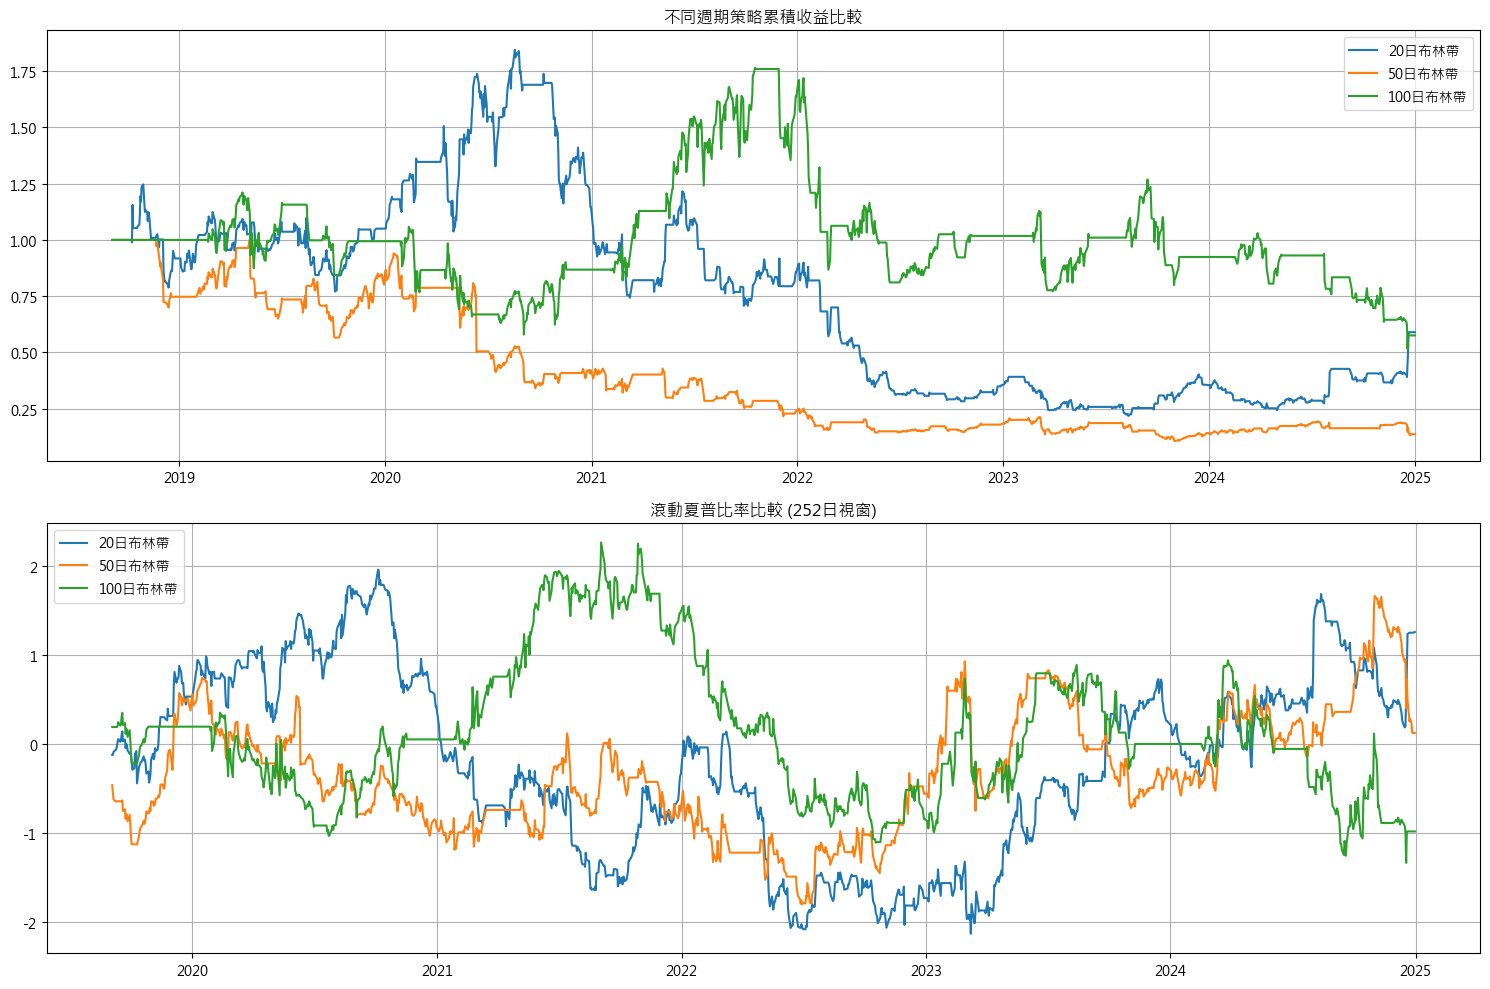


=== 不同週期策略比較 ===
              20日      50日     100日
年化報酬       -8.01%  -27.00%   -8.37%
總報酬       -40.99%  -86.31%  -42.42%
Sharpe比率     0.07    -0.59     0.06
交易次數          118       66       31
勝率         46.61%   46.97%   35.48%
平均持倉時間      10.1天    17.1天    35.5天
平均獲利        9.73%   11.06%   21.23%
平均虧損       -7.66%  -12.00%  -12.69%

50日週期交易明細:
   entry_date  entry_price  position  exit_date   exit_price    return  \
0  2018-11-20  2526.719971       1.0 2018-12-04  2066.560059 -0.182117   
1  2018-12-10  2584.320068       1.0 2018-12-18  2681.600098  0.037642   
2  2019-02-01  2261.120117      -1.0 2019-04-15  1655.680054  0.267761   
3  2019-05-06  1789.439941      -1.0 2019-05-08  1983.359985 -0.108369   
4  2019-05-14  1999.359985       1.0 2019-05-17  1871.359985 -0.064020   
..        ...          ...       ...        ...          ...       ...   
61 2024-07-31    46.117001       1.0 2024-08-02    54.459999  0.180909   
62 2024-10-28    53.060001       1.0 2024-11-01    56.

In [40]:
# 執行多週期回測
periods = [20,50,100]
strategies, results_summary = run_multi_period_backtest(vxx, periods)

# 查看特定週期的詳細交易記錄
period = 50
trade_stats, trades_df = strategies[period].analyze_trades()
print(f"\n{period}日週期交易明細:")
print(trades_df)

In [41]:
trades_df

,entry_date,entry_price,position,exit_date,exit_price,return,holding_period
0,2018-11-20,2526.719971,1.0,2018-12-04,2066.560059,-0.182117,14
1,2018-12-10,2584.320068,1.0,2018-12-18,2681.600098,0.037642,8
2,2019-02-01,2261.120117,-1.0,2019-04-15,1655.680054,0.267761,73
3,2019-05-06,1789.439941,-1.0,2019-05-08,1983.359985,-0.108369,2
4,2019-05-14,1999.359985,1.0,2019-05-17,1871.359985,-0.064020,3
...,...,...,...,...,...,...,...
61,2024-07-31,46.117001,1.0,2024-08-02,54.459999,0.180909,2
62,2024-10-28,53.060001,1.0,2024-11-01,56.310001,0.061251,4
63,2024-11-07,45.740002,-1.0,2024-11-08,45.029999,0.015523,1
64,2024-11-25,44.389999,-1.0,2024-12-19,49.590000,-0.117144,24


# Get vxz